# apartment-hunter

The dataset is a home sales data that comes from the official public records of home sales in the King County area, Washington State. The data set contains 21613 rows. Each represents a home sold from May 2014 through May 2015.

##### Libraries

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew, kurtosis

warnings.filterwarnings("ignore", category=FutureWarning)

##### Functions

In [37]:
def boxplot(data, label, title='', axis='y', figsize=(6,6)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=data) if axis == 'x' else sns.boxplot(y=data)
    if title != '':
        title = f'{title} '
    title = f'{title}Boxplot of {label}'
    plt.title(title)
    plt.xlabel(label) if axis == 'x' else plt.ylabel(label)
    plt.ticklabel_format(style='plain', axis=axis)
    plt.show()

def upper_whisker(data):
    q3 = data.quantile(0.75)
    iqr = data.quantile(0.75) - data.quantile(0.25)
    upper_whisker = q3 + 1.5 * iqr
    return upper_whisker

def lower_whisker(data):
    q1 = data.quantile(0.25)
    iqr = data.quantile(0.75) - data.quantile(0.25)
    lower_whisker = q1 - 1.5 * iqr
    return lower_whisker

def histogram(data, bins, label, title='' '''{title} {label} data distribution''', figsize=(8, 6), xticksrotation=0, skewness=(0, 0), kurtosis=(0, 0), mean=False, median=False, legend=False):
    plt.figure(figsize=figsize)
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    if mean == True:
        mean_price = data.mean()
        plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_price:.2f}')
    if median == True:
        median_price = data.median()
        plt.axvline(median_price, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_price:.2f}')
    if skewness != (0, 0):
        skewness_value = data.skew()
        plt.text(skewness[0], skewness[1], f'Skewness: {skewness_value:.2f}', transform=plt.gca().transAxes)
    if kurtosis != (0, 0):
        kurtosis_value = data.kurtosis()
        plt.text(kurtosis[0], kurtosis[1], f'Kurtosis: {kurtosis_value:.2f}', transform=plt.gca().transAxes)
    plt.xlabel(label)
    plt.ylabel('Frequency')
    if legend == True:
        plt.legend()
    if title != '':
        title = f'{title} '
    plt.title(f'{title}{label} data distribution')
    plt.xticks(rotation=xticksrotation)
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

##### Data processing: cleaning, transforming, and making data suitable for analysis  

In [38]:
df = pd.read_csv('../data/kc_house_data.csv')
df_original = df.copy()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [39]:
print(f'The dataframe has {df.shape[0]} lines and {df.shape[1]} columns.')

The dataframe has 21613 lines and 21 columns.


All columns:

In [40]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Existing data types:

In [41]:
df.dtypes.value_counts()

int64      15
float64     5
object      1
Name: count, dtype: int64

#### date

In [42]:
df.describe(include='object')

,date
count,21613
unique,372
top,20140623T000000
freq,142


We will convert date column to a datetime data type for easier manipulation and analysis:

In [43]:
df['date'] = pd.to_datetime(df['date'])
df.describe(include='datetime')


,date
count,21613
mean,2014-10-29 04:38:01.959931648
min,2014-05-02 00:00:00
25%,2014-07-22 00:00:00
50%,2014-10-16 00:00:00
75%,2015-02-17 00:00:00
max,2015-05-27 00:00:00


The Real Estate sales data begins on May 2, 2014, and ends on May 27, 2015.

#### Searching for duplicates:

In [44]:
duplicates = df[df.duplicated(['id'], keep=False)]
print('Lines with duplicating ids: ', len(duplicates))

Lines with duplicating ids:  353


Testing if all duplicates share the same features (except for price and date). Creating deduplication key in the df:

In [45]:
columns_to_include = ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
df['deduplication_key'] = df[columns_to_include].apply(lambda row: '_'.join(map(str, row)), axis=1)
duplicates = df[df.duplicated(subset='deduplication_key', keep=False)]
print('Lines with duplicating ids where all features remain the same: ', len(duplicates))

Lines with duplicating ids where all features remain the same:  353


All features remain the same except for price and date. This means the object was sold more than once.  We will create a *df_dedup_avg* with the average price of sales and another *df_dedup* with the latest sales price.

Creating deduplicated df **df_avg** with the average date and price values of duplicates:

In [46]:
filtered_duplicates = df[df.duplicated(subset='deduplication_key', keep=False)]
df_avg = df.copy()
df_avg['mean_price'] = filtered_duplicates.groupby('deduplication_key')['price'].transform('mean')
df_avg['mean_date'] = filtered_duplicates.groupby('deduplication_key')['date'].transform('mean')
df_avg = df_avg[~df_avg.duplicated(subset='deduplication_key')]
df_avg['price'] = df_avg['mean_price']
df_avg['date'] = df_avg['mean_date']
df_avg.drop(columns=['deduplication_key', 'mean_price', 'mean_date'], inplace=True)

Creating deduplicated **df_latest** with latest date values are left in the df:

In [47]:
df_latest = df.sort_values(by='date', ascending=True)
df_latest = df_latest.drop_duplicates(subset='deduplication_key', keep='last')
del df_latest['deduplication_key']
del df['deduplication_key']

One duplicate (id=6021501535) example in original **df**:

In [48]:
example_id = df[df['id'] == 6021501535]
example_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500
94,6021501535,2014-12-23,700000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500


THe same duplicate (id=6021501535) example in **df_avg**:

In [49]:
example_id = df_avg[df_avg['id'] == 6021501535]
example_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-10-08 12:00:00,565000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500


THe same duplicate (id=6021501535) example in **df_latest**:

In [50]:
example_id = df_latest[df_latest['id'] == 6021501535]
example_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,2014-12-23,700000.00,3,1.50,1580,5000,1.00,0,0,...,8,1290,290,1939,0,98117,47.69,-122.39,1570,4500


In [51]:
print('Number of rows in df: ', df.shape[0])
print('Number of rows in df_avg: ', df_avg.shape[0])
print('Number of rows in df_latest: ', df_latest.shape[0])

Number of rows in df:  21613
Number of rows in df_avg:  21436
Number of rows in df_latest:  21436


After deduplication dataframe should have 21436 remaining rows.

#### price

In [52]:
df.describe(include='float64')

,price,bathrooms,floors,lat,long
count,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,2.11,1.49,47.56,-122.21
std,367127.20,0.77,0.54,0.14,0.14
min,75000.00,0.00,1.00,47.16,-122.52
25%,321950.00,1.75,1.00,47.47,-122.33
50%,450000.00,2.25,1.50,47.57,-122.23
75%,645000.00,2.50,2.00,47.68,-122.12
max,7700000.00,8.00,3.50,47.78,-121.31


Checking if there are any price values where the decimal part is not equal to 0:

In [53]:
prices_with_nonzero_decimal = df[df['price'].astype(str).str.contains(r'\.\d*[1-9]')]
print(prices_with_nonzero_decimal['price'])

Series([], Name: price, dtype: float64)


The price column is our target variable. To enhance readability, we'll convert the column to integer.  
  
Additionally, we'll adjust pandas display option **to handle scientific notation**:
  
- `pd.set_option('display.float_format', lambda x: '%.2f' % x)` sets the display format for floating-point numbers to two decimal places.  
  
- `pd.reset_option('display.float_format')` resets the display format option.


In [54]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df['price'] = df['price'].astype(int)

Now we can see the price statistics in more readable format:

In [55]:
df.describe(include='int32')

,price
count,21613.00
mean,540088.14
std,367127.20
min,75000.00
25%,321950.00
50%,450000.00
75%,645000.00
max,7700000.00


The minimum price is **75'000**, the maximum price is **7'700'000**.  
The average price of properties is approximately **540'088**.  
The median price, or the midpoint of the dataset, is **450'000**.

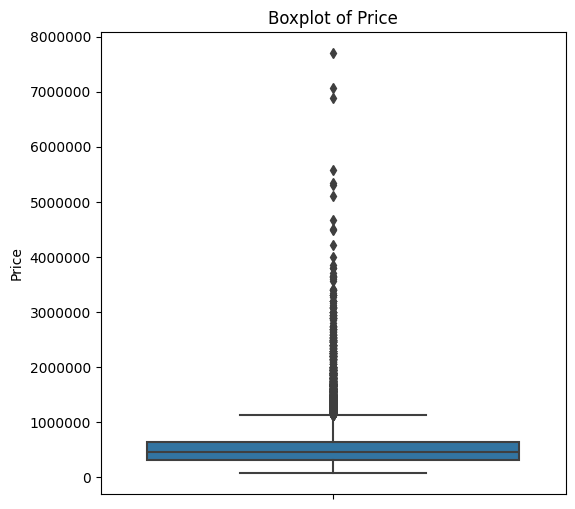

In [56]:
boxplot(df['price'], 'Price')

##### Calculating boxplot whiskers

Above is a modified box plot where the whiskers extend from the the box to the adjacent values. The adjacent values are defined as the lowest and highest observations that are still inside the region defined by the following limits:  
$$ Q1 - 1.5 \times \text{IQR} $$  
  
$$ Q3 + 1.5 \times \text{IQR} $$  
  
$$ \text{IQR (Interquartile range)} = Q3 - Q1 $$

$ \text{Q1 (First Quartile)} $: value that separates the lowest 25% of the data from the remaining 75%. Mathematically, it's the median of the lower half of the dataset (calculating from the median of the dataset).  

$ \text{Q3 (Third Quartile)} $: value that separates the lowest 75% of the data from the highest 25%. Mathematically, it's the median of the upper half of the dataset.  
  
  
Functions for calculating the upper and lower whisker limits are defined as upper_whisker(data) and lower_whisker(data) where data example is *df['price']*:

In [57]:
print('Upper whisker in price box plot is: ', upper_whisker(df['price']))

Upper whisker in price box plot is:  1129575.0


##### Boxplots of deduplicated dataframes:

**df_latest**:

df_latest:
Min price is:  75000.0
Max price is:  7700000.0
Median price is:  450000.0
Average price is:  541650.0
Lower whisker in price box plot is:  -155335.0
Upper whisker in price box plot is:  1125201.0


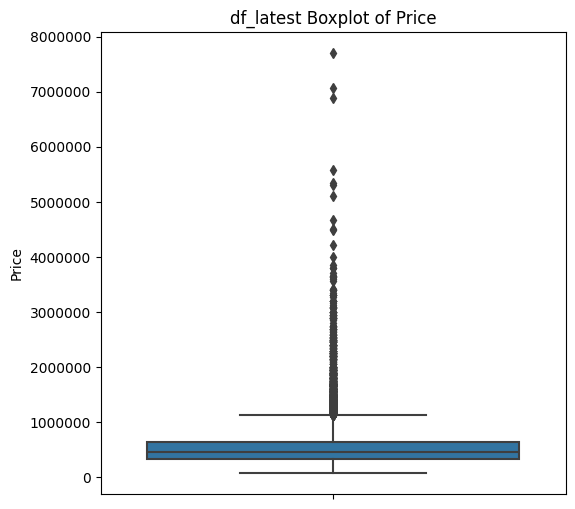

In [58]:
print('df_latest:')
print('Min price is: ', df_latest['price'].min())
print('Max price is: ', df_latest['price'].max())
print('Median price is: ', df_latest['price'].median())
print('Average price is: ', round(df_latest['price'].mean(), 1))
print('Lower whisker in price box plot is: ', round(lower_whisker(df_latest['price']), 1))
print('Upper whisker in price box plot is: ', round(upper_whisker(df_latest['price']), 1))
boxplot(df_latest['price'], 'Price', title='df_latest')

**df_avg**:

df_avg:
Min price is:  132000.0
Max price is:  1917500.0
Median price is:  347250.0
Average price is:  420453.5
Lower whisker in price box plot is:  -132240.6
Upper whisker in price box plot is:  878734.4


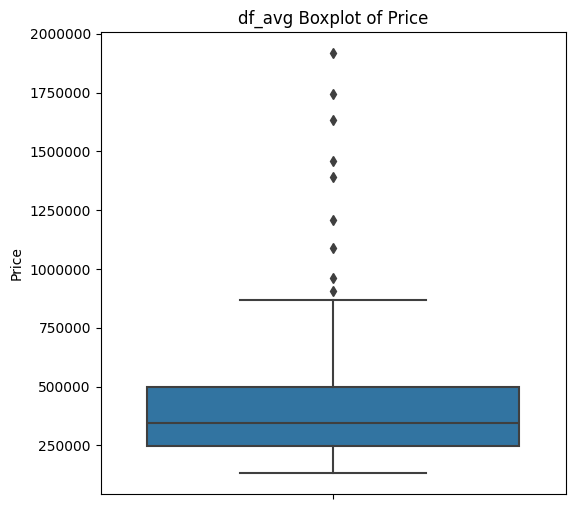

In [59]:
print('df_avg:')
print('Min price is: ', df_avg['price'].min())
print('Max price is: ', df_avg['price'].max())
print('Median price is: ', df_avg['price'].median())
print('Average price is: ', round(df_avg['price'].mean(), 1))
print('Lower whisker in price box plot is: ', round(lower_whisker(df_avg['price']), 1))
print('Upper whisker in price box plot is: ', round(upper_whisker(df_avg['price']), 1))
boxplot(df_avg['price'], 'Price', title='df_avg')

df_avg has less outliers and the price range is smaller.

##### Price data distribution excluding outliers

Home sale prices between May 2014 and May 2015 in the King County area, Washington State that are above *$1'129'575* are considered outliers.  
... or *1'125'201* in deduplicated df_latest,  
... or *878'734* in deduplicated df_avg

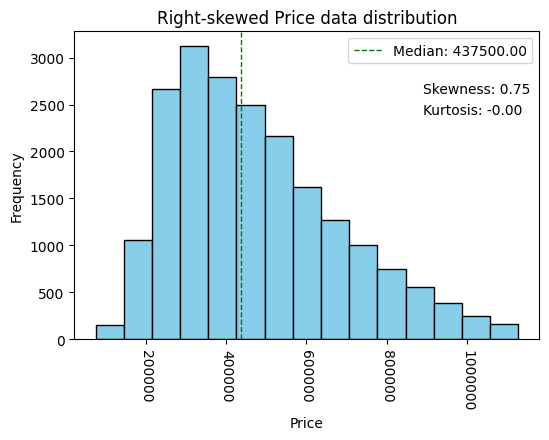

In [60]:
df_price_without_outliers = df[df['price'] <= upper_whisker(df['price'])]
histogram(df_price_without_outliers['price'], 15, 'Price', 'Right-skewed', figsize=(6, 4), xticksrotation=-90, skewness=(0.75, 0.8), kurtosis=(0.75, 0.73), median=True, legend=True)

**The price data distribution is right-skewed.**  
    
**Skewness**: The positive value indicates that the distribution is skewed towards the right side (peak to the left). The degree of asymmetry 0.75 is moderately skewed, indicating a noticeable but not extreme departure from symmetry. ("A value of skewness within the range +2 to −2 is considered acceptable for common statistical tests.") There are more lower-priced properties in the dataset, with relatively fewer properties having higher prices.
  
**Kurtosis**: The value of -0.0 for the price data distribution indicates a ***platykurtic distribution*** (kurt < 0). This means that the distribution has fewer extreme values (outliers) and is less peaked around the mean compared to a normal distribution. A kurtosis value of -0.0 suggests a very mild departure from the normal distribution in terms of peakedness and tail heaviness. **The distribution is close to being symmetrical**. 

---

Reference:
- Source: [ScienceDirect](https://www.sciencedirect.com/topics/social-sciences/skewness)
- Source: [Ben's Blog](https://datakuity.com/2021/08/24/skewness-kurtosis-powerbi-dax/)

Data distribution with deduplicated dataframes:

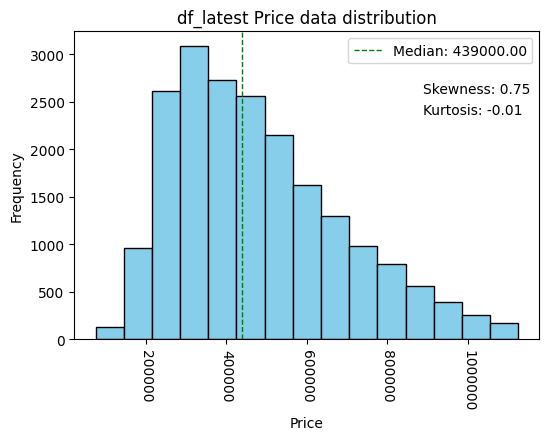

In [61]:
df_price_without_outliers = df_latest[df_latest['price'] <= upper_whisker(df_latest['price'])]
histogram(df_price_without_outliers['price'], 15, 'Price', 'df_latest', figsize=(6, 4), xticksrotation=-90, skewness=(0.75, 0.8), kurtosis=(0.75, 0.73), median=True, legend=True)

In [ ]:
df_price_without_outliers = df_avg[df_avg['price'] <= upper_whisker(df_avg['price'])]
histogram(df_price_without_outliers['price'], 15, 'Price', 'df_avg', figsize=(6, 4), xticksrotation=-90, skewness=(0.75, 0.8), kurtosis=(0.75, 0.73), median=True, legend=True)

Both df_latest and df_avg have similar skewness values (0.75 and 0.80, respectively), indicating a moderate right skew.  
  
Kurtosis: df_latest has a slightly lower kurtosis value (-0.01) compared to the original df (-0.00), while df_avg has a significantly higher kurtosis value (0.09). A positive kurtosis value suggests a ***leptokurtic distribution*** (Kurt > 0) that is more peaked. Therefore, df_latest has a distribution closer to a normal in terms of peakedness.

For further analysis we will use df_avg dataframe.

In [62]:
df = df_avg

#### sqft_living | sqft_above | sqft_basement

Square footage of living space ('sqft_living') is always equal to the sum of the square footage of the habitable space above ground ('sqft_above') and the square footage of the habitable space below ground ('sqft_basement').

In [63]:
df.describe(include='int64')

,id,bedrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
count,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00,21436.00
mean,4580765328.18,3.37,2082.70,15135.64,0.01,0.24,3.41,7.66,1790.96,291.74,1971.10,84.73,98077.86,1988.31,12785.96
std,2876589633.67,0.93,919.15,41538.62,0.09,0.77,0.65,1.17,829.03,442.78,29.39,402.43,53.47,685.70,27375.47
min,1000102.00,0.00,290.00,520.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,399.00,651.00
25%,2123700078.75,3.00,1430.00,5040.00,0.00,0.00,3.00,7.00,1200.00,0.00,1952.00,0.00,98033.00,1490.00,5100.00
50%,3904921185.00,3.00,1920.00,7614.00,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,1840.00,7620.00
75%,7308675062.50,4.00,2550.00,10696.25,0.00,0.00,4.00,8.00,2220.00,560.00,1997.00,0.00,98117.00,2370.00,10087.25
max,9900000190.00,33.00,13540.00,1651359.00,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,6210.00,871200.00


In [64]:
mismatched_rows = df[df['sqft_living'] != df['sqft_above'] + df['sqft_basement']]
mismatched_rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
